# The purpose of this file is to use machine learning (tensorflow and keras) to train a model that will be able to predict stock prices. This will eventually be integrated into a web-app to put onto my portfolio.

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
#Getting our data
df = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2019-12-17')
print('Number of dates available: ' + str(len(df)))
df.head()

Number of dates available: 2003


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792


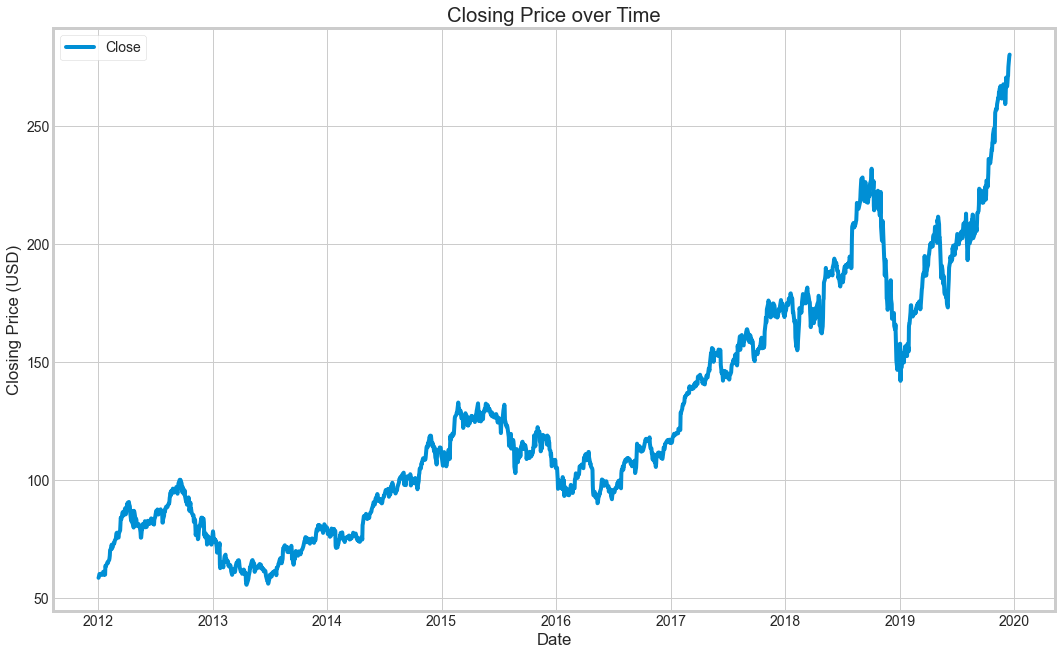

In [3]:
#Visualizing the closing price history
sns.set_style('whitegrid')
plt.figure(figsize = (16,10))
sns.lineplot(data = df[['Close']])
plt.ylabel('Closing Price (USD)')
plt.title('Closing Price over Time')
plt.show()

In [4]:
#Creating a new dataframe with only the close column
data = df[['Close']]

#Converting dataframe to numpy array
dataset = data.values

#Get the number of rows to train the model on (we want to train on 80% of the data)
training_data_len = math.ceil(len(dataset) * 0.8)

print('Length of our training dataset: ' + str(training_data_len))

Length of our training dataset: 1603


In [5]:
#Normalizing the data - we always do this whenever we input data into machine learning models (they perform better)
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
#Create the scaled training dataset
train_data = scaled_data[0: training_data_len, :]

#Split the data into x_train (independent training variables) and y_train (dependent training variables - target variable) data sets
x_train = []
y_train = []

#Here, we're basically taking every 60 "timepoints" of data, then appending the next value after that to y_train.
#The purpose is to use 60 data points to predict the 61st, over and over again, to train our model.
#0 - 59 --> we append the first y_train value (60), then 1 --> 60, we append the next y_train value (61)
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60: i, 0])
    y_train.append(train_data[i, 0])

In [7]:
#Convert the x_train and y_train to numpy arrays (proper format to use in the model)
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
#Reshape the data because the model expects a 3d input: number of samples, numebr of timepoints, and number of features
#Right now, our data is still 2-D
print('Old Shape: ' + str(x_train.shape))

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('New Shape: ' + str(x_train.shape))

Old Shape: (1543, 60)
New Shape: (1543, 60, 1)


In [9]:
#Build the LSTEM Model - the model is constructed in "layers"
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
#Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [11]:
#Train the model (fit is another word for train)
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

Epoch 1/1
1543/1543 [==============================] - 53s 35ms/step - loss: 9.2170e-04


In [12]:
#Creating the normalized testing dataset
test_data = scaled_data[training_data_len - 60: , :]

#Creating x_test (Values we want the model to use to predict y_test) and y_test (values we want our model to predict)
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60: i, 0])
    
print('Number of arrays with 60 values in x_test: ' + str(len(x_test)))
print('Number of values we want to predict: ' + str(len(y_test)))

Number of arrays with 60 values in x_test: 400
Number of values we want to predict: 400


In [13]:
#Converting the data to a numpy array
x_test = np.array(x_test)

#Reshape the data to make it 3-D (because that's what the model is expecting)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
#Get the models predicted price values, and un-normalizing them
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) 

In [15]:
#Evaluating our models performance - by getting the Root Mean Square Error (RMSE)
#Lower values of RMSE means it's a better fit
#A value of 0 mean that the predictions are perfect
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

5.786568265802501

C:\Users\dulur\.conda\envs\Tensorflow - Compatible\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


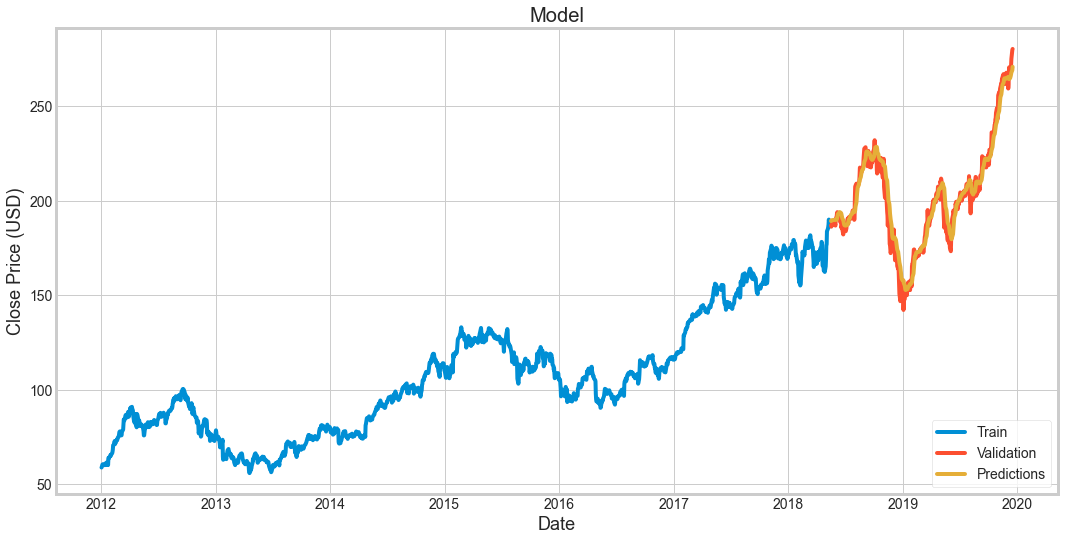

In [16]:
#Plot the data
train = data[: training_data_len]
valid = data[training_data_len: ]
valid['Predictions'] = predictions

plt.figure(figsize = (16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price (USD)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc = 'lower right')
plt.show()

In [17]:
#Show the valid and predicted prices as a dataframe
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,189.260605
2018-05-18,186.309998,189.657043
2018-05-21,187.630005,189.744980
2018-05-22,187.160004,189.783524
2018-05-23,188.360001,189.740479
...,...,...
2019-12-11,270.769989,266.144928
2019-12-12,271.459991,266.982025
2019-12-13,275.149994,267.915039


In [18]:
#Let's try to make a prediction
#Getting the data
apple_quote2 = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2019-12-17')

#Create a new dataframe
new_df = apple_quote2[['Close']]

#Get the last 60 days of closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

#Normalizing the data
last_60_days_normalized = scaler.transform(last_60_days)

#Create an empty list and appending the last 60 days worth of data
X_test = []
X_test.append(last_60_days_normalized)

#Convert the X_test dataset to a numpy array
X_test = np.array(X_test)

#Reshaping the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Getting the predicted, normalized price
predicted_price = model.predict(X_test)

#Undo the normalization to get the actual price
predicted_price = scaler.inverse_transform(predicted_price)
print("Predicted Price is: " + str(predicted_price[0][0]))

apple_quote2 = web.DataReader('AAPL', data_source = 'yahoo', start = '2019-12-18', end = '2019-12-18')
print('Actual Price is: ' + str(apple_quote2['Close'][0]))

Predicted Price is: 272.85068
Actual Price is: 279.739990234375
